# SPRING plot of all T cells only   
Based on all cell spring plot "all_cells_clean_iter3".

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Load data

In [5]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [6]:
# load obs with classifier results
adata.obs = rz.load_df('backups/obs_info_27563x30_200629_08h53.npz')

## Normalize counts

In [7]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,used_in_all_cells_clean_iter1_refCSF1Ri,sp_cl_all_cells_clean_iter1_refCSF1Ri_150,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3,sp_cl_all_cells_clean_iter3_100
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,...,True,19,False,True,68,mB cells,False,mB cells,True,13
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,...,True,19,False,True,4,mNK cells,False,mNK cells,True,33
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,...,True,145,False,True,75,mN4,False,mN4,True,31
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,...,True,138,False,True,41,mMac1,False,mMac1,True,18
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,...,True,67,False,True,1,mMono1,False,mMono1,True,89


## Save one copy of the data to master spring directory in a SPRING-compatible format  
Upon running this notebook, the resulting 2D visualization of the data is made available for exploration interactively using the [SPRING](https://academic.oup.com/bioinformatics/article/34/7/1246/4708233) tool in a web browser. This requires saving counts in a SPRING-compatible format.  

In [9]:
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri'

In [10]:
# already done in previous notebook

# save (once), may be slow
# srz.save_counts_for_spring(adata,project_dir)

## Data visualization in 2D. Exclude dblts, RBCs and Krt8+

### Select cells to visualize, name the plot, plotting parameters

In [13]:
use = adata.obs['used_in_all_cells_clean_iter3'].astype(bool)&\
      (adata.obs['*population'].isin(['mT1','mT2','mT3']))

use = use.values
print(use.sum())

2348


In [14]:
# add to obs, save
adata.obs['used_in_T_cells_only_iter2'] = use

In [15]:
# save the update obs dataframe
# no need to save the entire adata object, counts didn't change

fname = 'backups/obs_info_%dx%d_%s'%(adata.obs.shape[0],adata.obs.shape[1],rz.now())
rz.save_df(adata.obs,fname)

In [16]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object

cell_mask = adata.obs['used_in_T_cells_only_iter2'].astype(bool).values
print(cell_mask.sum(),len(cell_mask))
cdata = adata[cell_mask].copy() # all cells in this case

# chose a name for the spring subplot
plot_name = 'T_cells_only_iter2'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.X

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

2348 27563


{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2345, 2346, 2347]),
 'num_pc': 20,
 'plot_name': 'T_cells_only_iter2'}

In [17]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 10
pdict['min_cells'] = 5

# base index: which cells to use a reference to calculate the PC space?
pdict['base_ix'] = np.arange(E.shape[0])[adata.obs[cell_mask]['condition'].isin(['CSF1Ri']).values]

print(len(pdict['base_ix']))

pdict

1247


{'k': 10,
 'cell_mask': array([False, False, False, ..., False, False, False]),
 'min_counts': 10,
 'min_cells': 5,
 'base_ix': array([   0,    1,    2, ..., 1244, 1245, 1246]),
 'num_pc': 20,
 'plot_name': 'T_cells_only_iter2'}

### Gene selection

### Exclude mitochondrial and ribosomal genes

In [18]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

mt-
['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te', 'mt-Tf', 'mt-Tg', 'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2', 'mt-Tt', 'mt-Tv', 'mt-Tw', 'mt-Ty']


Rps
['Rps10', 'Rps11', 'Rps12', 'Rps12-ps3', 'Rps13', 'Rps14', 'Rps15', 'Rps15a', 'Rps16', 'Rps17', 'Rps18', 'Rps19', 'Rps19bp1', 'Rps2', 'Rps20', 'Rps21', 'Rps23', 'Rps24', 'Rps25', 'Rps26', 'Rps27', 'Rps27a', 'Rps27l', 'Rps27rt', 'Rps28', 'Rps29', 'Rps3', 'Rps3a1', 'Rps4x', 'Rps5', 'Rps6', 'Rps6ka1', 'Rps6ka2', 'Rps6ka3', 'Rps6ka4', 'Rps6ka5', 'Rps6ka6', 'Rps6kb1', 'Rps6kb2', 'Rps6kc1', 'Rps6kl1', 'Rps7', 'Rps8', 'Rps9', 'Rpsa']


Rpl
['Rpl10', 'Rpl10-ps3', 'Rpl10a', 'Rpl10l', 'Rpl11', 'Rpl12', 'Rpl13', 'Rpl13a', 'Rpl13a-ps1', 'Rpl14', 'Rpl15', 'Rpl17', 'Rpl18', 'Rpl18a', 'Rpl19', 'Rpl21', 'Rpl22', 'Rpl22l1', 'Rpl23', 'Rpl23a

### Exclude cell cycle genes   
Upon initial visualization of the data, I observed a few small clusters dominated by cell cycle and composed of different immune cells types. Here, I prefer these cycling cells to land in their clusters of origin, so I exclude the cell cycle genes using a previously annotate lists.

In [19]:
# also load cell cycle genes. The same list used from regressing out the cell cycle in Seurat and Scanpy,
# except that here I simply exclude those genes, no linear regression.

# download cell cycles genes from here:
# https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1
# place into the working directory

ccpath = './cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt'
cell_cycle_genes = np.loadtxt(ccpath,dtype='str')

print(len(cell_cycle_genes),len(set(cell_cycle_genes)))

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

97 97


In [20]:
# whoops, looks like these are human genes, and I have mouse data
# download a mouse-human orthology table fro mgi
# in general, for this purpose I want to be permissive

#opath = "http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt"
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#!mkdir mouse_human_orthologs
#!cd mouse_human_orthologs && curl -LO $opath
#!echo "Downloaded from $opath \n on $toappend" > mouse_human_orthologs/readme.txt

In [21]:
oframe = pd.read_csv('mouse_human_orthologs/HMD_HumanPhenotype.rpt',sep='\t',header=None)

# human to mouse dictionary
h2m = {}
for h,m in zip(oframe[0],oframe[4]):
    if h not in h2m:
        h2m[h] = []
    h2m[h] = h2m[h]+[m]

    
# translate s_genes
# check the length before
print(len(s_genes))

# translate
s_genes = [h2m[i] for i in s_genes if i in h2m]
print(len(s_genes)) # if fewer, some human genes were not in the dictionary

# flatten
s_genes = rz.flatten_list_of_lists(s_genes)
print(len(s_genes))

# make sure no gene names repeated after translation
s_genes = rz.oset(s_genes)
print(len(s_genes))

# same with g2m_genes
g2m_genes = [h2m[i] for i in g2m_genes if i in h2m]
print(len(g2m_genes)) # if fewer, some human genes were not in the dictionary

# flatten
g2m_genes = rz.flatten_list_of_lists(g2m_genes)
print(len(g2m_genes))

# make sure no gene names repeated after translation
g2m_genes = rz.oset(g2m_genes)
print(len(g2m_genes))

# overwrite cell cycle genes
cell_cycle_genes = s_genes + g2m_genes
print(len(cell_cycle_genes))
cell_cycle_genes = rz.oset(cell_cycle_genes)
print(len(cell_cycle_genes))

43
42
42
42
52
52
52
94
94


In [22]:
# make a signature out of g2m genes (I found this list more specific to cycling clusters)
# gene mask
gmaskcc = np.in1d(cdata.var_names,g2m_genes)

# select normalized counts
e = E[:,gmaskcc].toarray()

# decision: use z-scoring for combining. I also like dense ranking
z = scipy.stats.zscore(e,axis=0)
signature = z.mean(axis=1)

# get the correlation to this g2m signature for every gene (code not very elegant but works):
coefs = []
step = 5000
sign = scipy.sparse.csr_matrix(signature)
for i in range(0,E.shape[1],step):
    c = srz.sparse_corrcoef(E.T[i:i+step,:],sign)
    coefs.append(np.array(c[-1,:-1])[0])
    
coefs = np.concatenate(coefs)
coefs = np.nan_to_num(coefs)

/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.05 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.06 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.06 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.07 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.05 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.06 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


0.03 min.
0.04 min.
0.00 min.


/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: divide by zero encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))
/Users/rapolaszilionis/Google Drive/analyses/Pittet_lab/202005_CSF1Ri/utility_functions_200517_09h14/rz_utility_spring.py:138: RuntimeWarning: invalid value encountered in true_divide
  coeffs = C / np.sqrt(np.outer(d, d))


1052


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


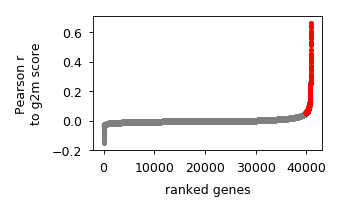

In [23]:
# select threshold:
ccts = 0.05
corrmask = coefs>ccts
print(corrmask.sum())

# add to the list of genes to avoid:


# show in a plot
a,fig,gs=rz.startfig(5,3)
y = np.sort(coefs)
x = np.arange(len(y))
yred = y[y>ccts]
xred = x[y>ccts]

a.scatter(x,y,c='0.5',s=2)
a.scatter(xred,yred,c='r',s=2)

a.set_ylabel('Pearson r\nto g2m score')
a.set_xlabel('ranked genes');

### Further gene filtering on abundance and variability

In [24]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
    
    
# add the correlated genes 
exclude_gene_names.append(list(adata.var_names[corrmask]))
exclude_gene_names.append(cell_cycle_genes)
    
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
pdict['cell_cycle_genes'] = cell_cycle_genes
pdict['genes_correlated_to_g2m'] = list(adata.var_names[corrmask])
print('%d genes excluded based on name or correlation to cell cycle'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E[pdict['base_ix'],:],
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

1366 genes excluded based on name or correlation to cell cycle
5594 genes passing abundance filter


In [25]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

36702
35748
5182 surviving genes so far


In [26]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
isexpr = np.array(E[pdict['base_ix'],:].sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[pdict['base_ix'],:][:,isexpr])

25222 genes with non-zero expression


In [27]:
# get genes above mode, i.e. any that can be considered variable
gabmod = cdata.var_names[isexpr][pdict['v_score_dict']['var_gene_mask']]
print(len(gabmod),'variable genes')

17526 variable genes


### Chose a fixed number of top variable genes

In [28]:
# Chose a fixed number of top variable genes
nvar = 2000
topvar = cdata.var_names[combmask&isexpr]\
        [np.argsort(pdict['v_score_dict']['v_scores'][combmask[isexpr]])][-nvar:]

In [29]:
# hum, cd4 and cd8 do not separate well, did I include these genes?
gtc = ['Cd4','Cd8b1','Cd8a','Cxcr6','Ccr7','Foxp3']
for i in gtc:
    print(i, i in topvar)

Cd4 True
Cd8b1 True
Cd8a True
Cxcr6 True
Ccr7 True
Foxp3 True


In [30]:
# update combmask:
combmask = np.in1d(cdata.var_names,topvar)
print(combmask.sum(),'abundant and variable genes')

2000 abundant and variable genes


In [31]:
# record genes surviving selection
pdict['genes_used'] = cdata.var_names[combmask]
print(len(pdict['genes_used']),'genes surviving all filters')

2000 genes surviving all filters


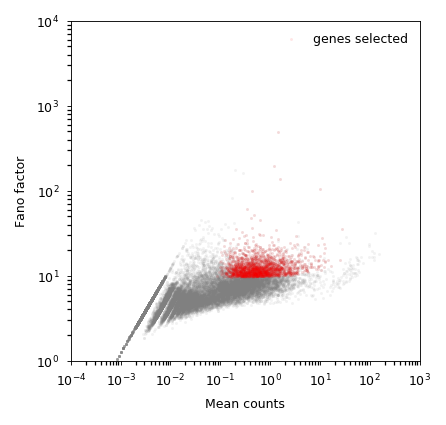

In [32]:
# plot a fano factor vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)

plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],
            lw=0,color='r',alpha=0.1,s=s,label='genes selected')

plt.legend()

plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

### PCA with batch correction  
The batch correction consists of using eigenvalues calculated on cells from one condition (reference, "base_ix") for transforming the data from all cells

In [33]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(2348, 40930)
(2348, 2000)


In [34]:
help(srz.zscore_sparse)

Help on function zscore_sparse in module rz_utility_spring:

zscore_sparse(E, base_ix=[], var_stab_only=False)
    zscores along the columns. If specified, only base_ix rows with be used
    to calculate mean and st. dev. Inspired by "get_pca" function from
    https://github.com/AllonKleinLab/SPRING_dev/blob/master/data_prep/helper_functions.py
    2018 12 07
    
    Input:
        E - sp.sparse matrix, cells x genes
        base_ix - np.array with positional index
        var_stab_only - variance stabilize only, bool
    returns:
        Zscores, if var_stab_only==True,
        then sparse matrix, else and np.array



In [35]:
# Z score calculating the mean and variance on base_ix (i.e. reference) cell only
Z = srz.zscore_sparse(cdata.X,base_ix=pdict['base_ix'])

In [36]:
# find the number of non-random PCs.
d = srz.find_num_pc(Z[pdict["base_ix"],:],start_pc=80,sparse=False,n=10)

calculating the first 80 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 44 	 0.02 min.
2 	 45 	 0.03 min.
3 	 47 	 0.04 min.
4 	 44 	 0.06 min.
5 	 42 	 0.07 min.
6 	 44 	 0.08 min.
7 	 43 	 0.09 min.
8 	 43 	 0.11 min.
9 	 44 	 0.12 min.
10 	 43 	 0.13 min.


In [37]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_

print(d['num_pc'])

42


In [38]:
# transform observed data
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(2348, 42)


### Draw graph

In [39]:
# Place the principle component data into an AnnData object to use scanpynian functions downstream

P = AnnData(P)

# get kNN graph
# ignore the error message: https://github.com/lmcinnes/umap/issues/87
k = pdict['k']
print(k, 'neighbors')
sc.pp.neighbors(P,k,use_rep='X')

# Draw force-directed graph.
# This is just to get an initial version of xy coordinates
# Nodes are further relaxed in interactive SPRING mode.
sc.tl.draw_graph(P, layout='fa')

10 neighbors
computing neighbors


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03)
drawing single-cell graph using layout 'fa'
    finished (0:00:11)


### Save graph and cell coloring data for interactive exploration using the SPRING tool  
- Force layout is finished in the browser version of SPRING. It also uses forceAtlast2 (just as draw graph) but is performed on an unweighted version of the graph, therefore the discrepancies between xy coordinates obtain in the browser and by running sc.tl.draw_graph.  
- Desired column of adata.obs can be specific to color cells.

In [40]:
cdata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,sp_cl_all_cells_clean_iter1_refCSF1Ri_150,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3,sp_cl_all_cells_clean_iter3_100,used_in_T_cells_only_iter2
6,bcDOTX,CSF1Ri_1_1,4013,8.74657,Blz1a,CSF1Ri_1,CSF1Ri,T_8Mem_Sp,mT1,T,...,84,False,True,59,mT1,True,mT1,True,76,True
9,bcAUSC,CSF1Ri_1_1,4136,8.31721,Blz1a,CSF1Ri_1,CSF1Ri,T_8Mem_Sp,mT1,T,...,84,False,True,99,mT1,True,mT1,True,76,True
30,bcFQKY,CSF1Ri_1_1,2205,6.71202,Blz1a,CSF1Ri_1,CSF1Ri,T_8Nve_LN,mT1,T,...,54,False,True,11,mT1,True,mT1,True,28,True
33,bcDCDR,CSF1Ri_1_1,2103,8.84451,Blz1a,CSF1Ri_1,CSF1Ri,T_8Nve_LN,mT1,T,...,113,False,True,44,mT1,True,mT1,True,21,True
34,bcAVSY,CSF1Ri_1_1,1857,5.76198,Blz1a,CSF1Ri_1,CSF1Ri,T_4Nve_LN,mT1,T,...,27,False,True,44,mT1,True,mT1,True,21,True


In [41]:
# continuous per-cell metadata
contvars = ['total_counts','pct_counts_mito','doublet_score']
# categorical
catvars = ['library','mouse','condition','closest_Immgen',
           'closest_Zilionis2019_mouse_minor','closest_Immgen_simplified',
          'top3pct_dbtl_score','top5pct_dbtl_score','top10pct_dbtl_score']

In [42]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    P.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    P.obs[catvar] = cdata.obs[catvar].astype(str).values

In [43]:
plot_name = pdict['plot_name']
print(plot_name)

# note1: the output of sc.pp.neighbors(P,k,use_rep='X') is a weighted graph.
# but it is saved as an unweighted graph for SPRING
# further clustering and any graph-based analyses are performed
# on the UNweighted graph obtained by loading graph data from the
# spring directory

# note2: at the moment of running this notebook export_spring_plot was not updated to work with
# scanpy versions higher than 1.4.4.post1. Email me at rapolas.zilionis@gmail.com if you happen
# to be running this notebook and the issue is still not fixed.



srz.export_spring_plot(P,
                       project_dir,
                       plot_name,
                       
                       # specify the normalized expression values
                       # this is solely to calculate where the default saturation
                       # of gene expression is in the interactive explorer
                       E = adata[cell_mask].X.tocsc(), # tocsc() super important here
                       gene_list = adata.var_names.values,
                       cell_groupings=catvars,
                       custom_color_tracks=contvars,
                      )

T_cells_only_iter2
Writing subplot to /Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet/CSF1Ri/T_cells_only_iter2/


In [44]:
# the function "srz.export_spring_plot" needs to be updated to properly save the cell filter. To do.
# for now I use a hack and save manually using the code in this cell.

subplot_dir = project_dir+'/'+plot_name + '/'
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]  
np.savetxt(subplot_dir + 'cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_dir + 'cell_filter.npy', cell_ix)

In [45]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)

### Add my favorite color dictionary to the interactive version of SPRING

In [46]:
# Select spring plot
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'T_cells_only_iter2/'

# get cell filter:
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

In [47]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'categorical_coloring_data.json')

# color dictionary of dictionaries
cdd = {key:value['label_colors'] for key,value in cg0.items()}
cg = {key:value['label_list'] for key,value in cg0.items()}

# happen to have the color codes used in our Immunity paper
cdd['closest_Zilionis2019_mouse_minor'] = {
            "mB cells": "#4666B0", 
            "mBasophils": "#4c2e4d", 
            "mDC1": "#ff0000", 
            "mDC2": "#ff9900", 
            "mDC3": "#990000", 
            "mMono1": "#e1e74b", 
            "mMono2": "#6d700f", 
            "mMono3": "#0099ff", 
            "mMonoDC": "#00cc00", 
            "mMac1": "#ff3399", 
            "mMac2": "#66ffff", 
            "mMac3": "#9966ff", 
            "mMac4": "#33cccc", 
            "mN1": "#0a5e75", 
            "mN2": "#66ffcc", 
            "mN3": "#008055", 
            "mN4": "#12a9d3", 
            "mN5": "#666699", 
            "mN6": "#EE2C7C", 
            "mNK cells": "#1F6935", 
            "mT1": "#ffd700", 
            "mT2": "#ba0898", 
            "mT3": "#cc263c", 
            "mpDC": "#a094ff"
                                    }


# append!
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

In [49]:
# make an html copy of THIS notebook

moveto = project_dir+'/'+plot_name+'/'
!jupyter nbconvert part19_sping_plot_of_T_only.ipynb
!mv part19_sping_plot_of_T_only.html "$moveto"

[NbConvertApp] Converting notebook part19_sping_plot_of_T_only.ipynb to html
[NbConvertApp] Writing 410740 bytes to part19_sping_plot_of_T_only.html
